# TITANIC - exploratory data analysis + catboost + optuna

Motivation:
- get aquainted with titanic dataset
- learn new visualization tricks
- learn using catboost with optuna

Plan:
- import dataset
- read dataset thechical characteristics
- study each feature individually
- try to split complex features into simple ones
- fill missing values (gently)
- study features in groups, look for patterns
- make qualitative assessment of features for applicability for use in machine learning
- define functions for ML and hyperparameter tuning
- manually select features and check prediction accuracy with cross-val
- submit result with highest accuracy on c-v

# Technical imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm, Normalize
from matplotlib.lines import Line2D
from scipy import stats as st
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors
from catboost import CatBoostClassifier
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, naive_bayes, svm
import shap
import optuna
import warnings
import catboost as cb
from catboost.utils import get_gpu_device_count
from catboost import Pool
warnings.filterwarnings('ignore')

import sys
# if 'BorutaShap' not in sys.modules:
#     print('Installing BorutaShap')
#     !{sys.executable} -m pip install -U BorutaShap --quiet #--default-timeout=100 -i https://pypi.tuna.tsinghua.edu.cn/simple
#     from BorutaShap import BorutaShap

sns.set_theme()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

percentiles = [0.25, 0.5, 0.75]

random_state = 12345

GPU_aval = get_gpu_device_count() > 0
print('GPU avaliable:', GPU_aval)
#import os
#or dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#        print(os.path.join(dirname, filename))

GPU avaliable: False


Error 35 (CUDA driver version is insufficient for CUDA runtime version) ignored while obtaining device count


# Dataset import

In [2]:
dat = pd.read_csv('/kaggle/input/titanic/train.csv')
dat.columns = [i.lower() for i in dat.columns]
dat.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Features list:
- PassengerId - unique ID
- Survived - status 1 (yes) or 0 (no)
- Pclass - passenger class from 1 to 3. 3 being lowest
- Name - full name including some titles
- Sex - male or female
- Age - age
- SibSp - number of siblings / spouses aboard the Titanic
- Parch - of parents / children aboard the Titanic
- Ticket - ticket number (different format)
- Fare - ticket price (per person!)
- Cabin - cabin number. Generally, it includes a letter and a number
- Embarked - port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Let's simplify the features addressing.

In [3]:
passengerid = 'passengerid'
survived = 'survived'
pclass = 'pclass'
name = 'name'
sex = 'sex'
age = 'age'
sibsp = 'sibsp'
parch = 'parch'
ticket = 'ticket'
fare = 'fare'
cabin = 'cabin'
embarked = 'embarked'
family_name = 'family_name'
family_number = 'family_number'
family_size = 'family_size'
marital_status = 'marital_status'
nickname = 'nickname'
deck = 'deck'
room = 'room'
male = 'male'
female = 'female'
features = 'features'
targets = 'targets'

dat['embarked'] = dat['embarked'].replace({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})

Let's look at missing values.

In [4]:
display(dat.info())
dat.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are missing values in 3 columns. Let's visualize them.

,missing_values,% of total
cabin,687,77.100000
age,177,19.900000
embarked,2,0.200000
passengerid,0,0.000000
survived,0,0.000000
pclass,0,0.000000
name,0,0.000000
sex,0,0.000000
sibsp,0,0.000000
parch,0,0.000000


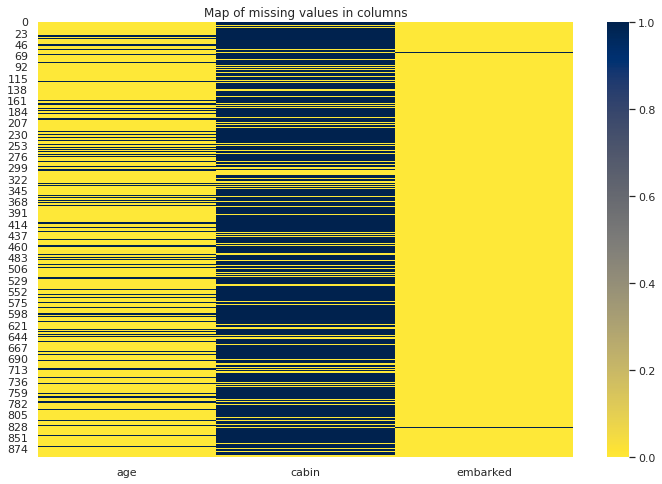

In [5]:
report = dat.isna().sum().to_frame().rename(columns = {0: 'missing_values'})
report['% of total'] = (100 * report['missing_values'] / dat.shape[0]).round(1)
display(report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm'))

cols_with_misses = [i for i in dat.columns if dat[i].isnull().sum() > 0]
sns.heatmap(dat[cols_with_misses].isnull(), cmap='cividis_r').set(title='Map of missing values in columns');

There are missing values in 3 columns: 
- cabin. Lots of nan. Maybe there in no info on low class passengers?
- age. 20% nan. Quite a lot
- embarked. Only 2 nan

There is no explicit correlation between missing values in columns.

Let's see how many "good" rows we have.

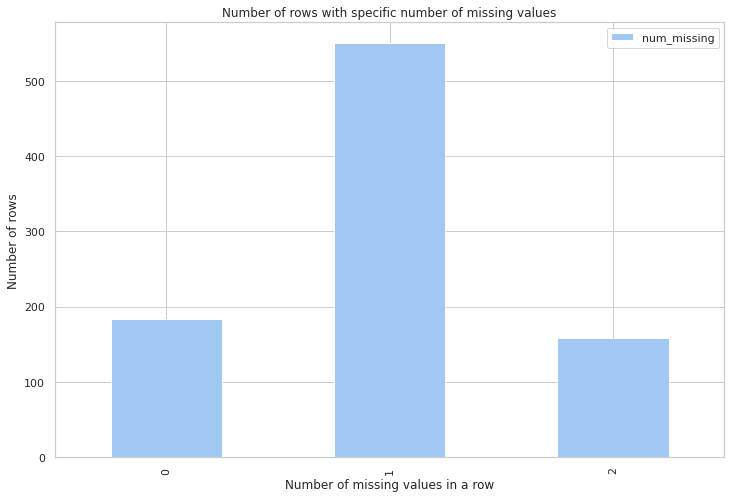

In [6]:
tmp = dat.copy()

for col in tmp.columns:
    missing = tmp[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  
        tmp['{}_ismissing'.format(col)] = missing

ismissing_cols = [col for col in tmp.columns if 'ismissing' in col]
tmp['num_missing'] = tmp[ismissing_cols].sum(axis=1)
tmp['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing').set(
    title='Number of rows with specific number of missing values', 
    xlabel='Number of missing values in a row', ylabel='Number of rows');

We have about 200 pervect rows and another 500 with 1 missing value.

# Pre-processing

## Duplicates

In [7]:
display(sum(dat.duplicated()))
display(sum(dat.passengerid.duplicated()))
display(sum(dat.name.duplicated()))

0

0

0

There are no explicit duplicates.

## Individual column analisys

### PassengerId

In [8]:
len(dat.passengerid) - len(dat.passengerid.unique())

0

Numer of unique values = overall number of values, so each value is unique.

It's very likely that this feature will give us nothing in analisys.

### Survived

In [9]:
def pie_chart (df, col_name):
    tmp = df[col_name].value_counts().sort_values()
    tmp.plot(kind='pie', y=col_name, startangle=90)
    tmp = pd.DataFrame([tmp, tmp/tmp.sum()]).T
    tmp.columns = ['Count', 'Part_%']
    display(tmp.sort_values(by='Count', ascending=False))
    print('Missing values:', df[col_name].isna().sum())

,Count,Part_%
0,549.0,0.616162
1,342.0,0.383838


Missing values: 0


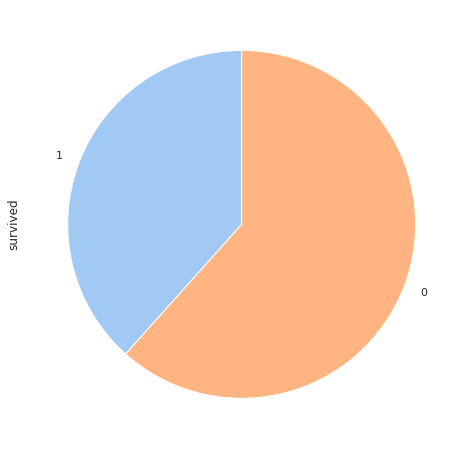

In [10]:
pie_chart(dat, survived)

About 38% survived.

### Pclass

,Count,Part_%
3,491.0,0.551066
1,216.0,0.242424
2,184.0,0.206510


Missing values: 0


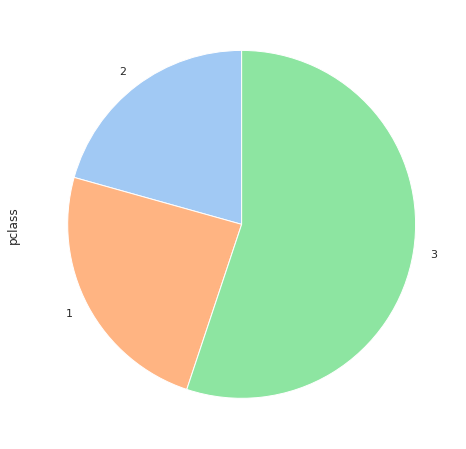

In [11]:
pie_chart(dat, pclass)

- more than 50% of 3rd class
- about 25% of 1st class
- about 20% of 2 class (less than 1st? Strange)

### Name

Let's check if all values are unique.

In [12]:
len(dat.name) - len(dat.name.unique())

0

It may seem that names are as useless as passengerID since the all are unique categorical values. But! There may be some additional info buried in those strings.

In [13]:
display(pd.concat([dat.name.head(5), dat.name.tail(5)]))

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: name, dtype: object

As a matter of fact, there is lots of info here:
- females are called Mrs. or Miss. so there is some info about marital status here
- we can get last names (the first word in column) and try to analyze families as a whole
- some passengers have their preferred name and also original name
- some passengers have a nicknamt like "Carrie"

Let's start with creating new column - family name.

We will exclude people who have zero SibSp + Parch on board - we think they are travelling without family.

Obviously in this calculation we didn't include parents on wife side and stuff like that, so it is a rough approximation.

Total passengers = 891, unique family names = 667
Part of unique family names = 0.7485970819304153


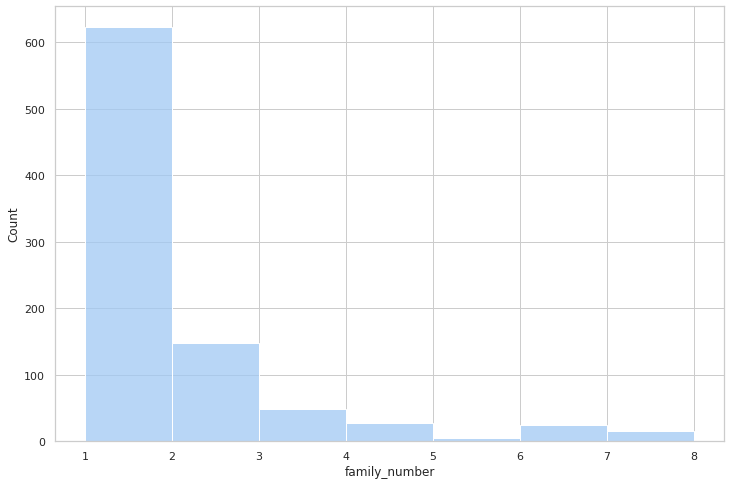

In [14]:
dat[family_name] = dat[name].str.split(',').str[0]
print(f'Total passengers = {len(dat[family_name])}, unique family names = {len(dat[family_name].unique())}')
print(f'Part of unique family names = {len(dat[family_name].unique()) / len(dat[family_name])}')

dat[family_number] = dat[(dat.sibsp > 0) | (dat.parch > 0)].groupby(family_name)[family_name].transform('count')
dat[family_number] = dat[family_number].fillna(1)
sns.histplot(data=dat, x=family_number, binwidth=1);

Now to the marital status.
- Mrs - married
- Miss - not married
- Ms - unknown

mr.     577
miss    182
mrs.    125
ms.       7
Name: marital_status, dtype: int64

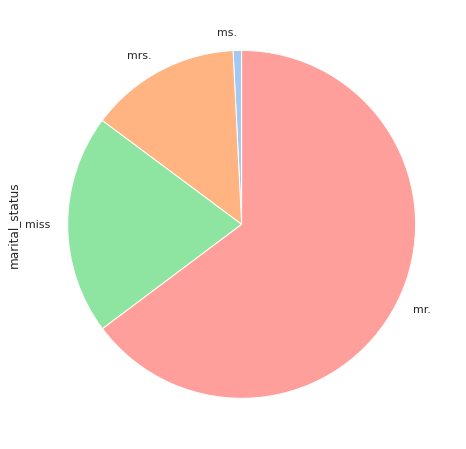

In [15]:
dat[marital_status] = np.nan
for i in ['mr.', 'mrs.', 'miss', 'ms.']:
    dat.loc[dat[name].str.lower().str.contains(' ' + i), marital_status] = i
dat.loc[dat[sex] == male, marital_status] = dat.loc[dat[sex] == male, marital_status].fillna('mr.')
dat.loc[dat[sex] == female, marital_status] = dat.loc[dat[sex] == female, marital_status].fillna('ms.')
dat[marital_status].value_counts().sort_values().plot(kind='pie', startangle=90)
display(dat[marital_status].value_counts())

In [16]:
dat[dat[marital_status] == 'ms.']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,Cherbourg,Aubart,1.0,ms.
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,Southampton,Reynaldo,1.0,ms.
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,Cherbourg,Duff Gordon,2.0,ms.
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,Cherbourg,Sagesser,1.0,ms.
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,Cherbourg,Mayne,1.0,ms.
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,Southampton,Rothes,1.0,ms.
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,Southampton,Leader,1.0,ms.


I've googled some of Ms. Some of them were married and some - not. It seems we can't get such info only from this dataset.

Some passengers had some sort of nicknames/aliases written like "Carrie". We will extract them in separate column and briefly analyze.

In [17]:
dat[nickname] = dat[name].str.extract(r'("[^"]+")')
display(dat[dat.nickname.notna()].info())
display(dat[dat.nickname.notna()].describe())
display(dat[dat.nickname.notna()][sex].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 22 to 888
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   passengerid     53 non-null     int64  
 1   survived        53 non-null     int64  
 2   pclass          53 non-null     int64  
 3   name            53 non-null     object 
 4   sex             53 non-null     object 
 5   age             35 non-null     float64
 6   sibsp           53 non-null     int64  
 7   parch           53 non-null     int64  
 8   ticket          53 non-null     object 
 9   fare            53 non-null     float64
 10  cabin           8 non-null      object 
 11  embarked        53 non-null     object 
 12  family_name     53 non-null     object 
 13  family_number   53 non-null     float64
 14  marital_status  53 non-null     object 
 15  nickname        53 non-null     object 
dtypes: float64(3), int64(5), object(8)
memory usage: 7.0+ KB


None

,passengerid,survived,pclass,age,sibsp,parch,fare,family_number
count,53.000000,53.000000,53.000000,35.000000,53.000000,53.000000,53.000000,53.000000
mean,428.056604,0.716981,2.415094,23.685714,0.433962,0.415094,23.783649,1.584906
std,243.806782,0.454776,0.770463,13.064369,1.201112,0.770463,37.089185,1.133985
min,23.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,205.000000,0.000000,2.000000,15.500000,0.000000,0.000000,7.795800,1.000000
50%,382.000000,1.000000,3.000000,21.000000,0.000000,0.000000,15.500000,1.000000
75%,654.000000,1.000000,3.000000,35.500000,0.000000,0.000000,26.250000,2.000000
max,889.000000,1.000000,3.000000,49.000000,8.000000,2.000000,262.375000,7.000000


female    32
male      21
Name: sex, dtype: int64

There are 53 nicknames. It seems these people don't really stand out - they are from different classes, they have different sex (although more women) and overall same survival rate (a bit higher, but again - there are more women in this list).

### Sex

,Count,Part_%
male,577.0,0.647587
female,314.0,0.352413


Missing values: 0


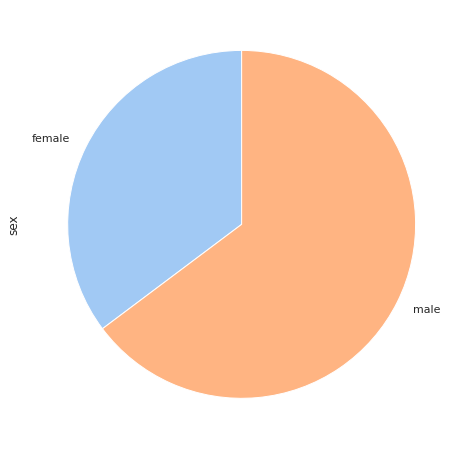

In [18]:
pie_chart(dat, sex)

### Age

Missing values: 177


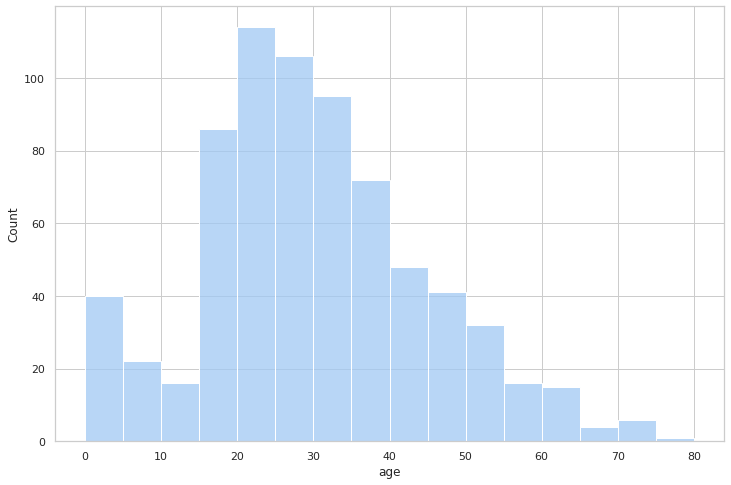

In [19]:
sns.histplot(data=dat, x=age, bins=np.arange(0, dat.age.max() + 1, 5))
dat.age.describe(percentiles=percentiles)
print('Missing values:', dat[age].isna().sum())

- it looks a bit like normal distribution, but with heavy right tail and lots of zeroes.

Let's look at those "zeroes".

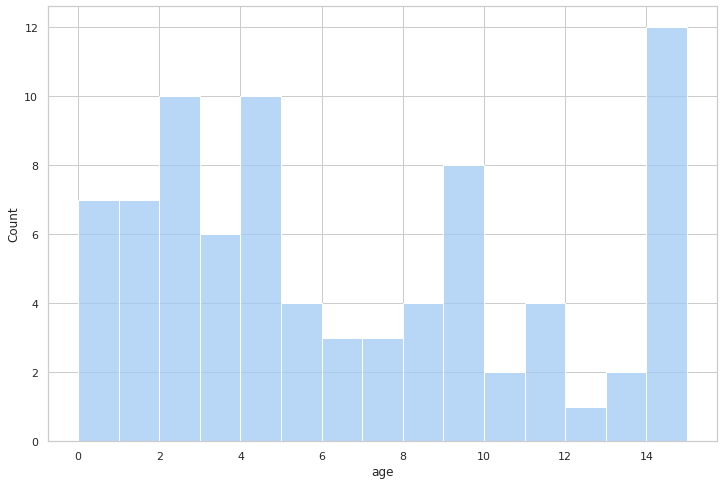

In [20]:
sns.histplot(data=dat, x=age, bins=np.arange(0, 16, 1));

In [21]:
tmp = dat[dat[age].isna()]
print(len(tmp) / len(dat))
display(tmp.head(7))

0.19865319865319866


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Queenstown,Moran,1.0,mr.,NaN
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,Southampton,Williams,1.0,mr.,NaN
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,Cherbourg,Masselmani,1.0,mrs.,NaN
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,Cherbourg,Emir,1.0,mr.,NaN
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Queenstown,O'Dwyer,1.0,miss,"""Nellie"""
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,Southampton,Todoroff,1.0,mr.,NaN
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,Cherbourg,Spencer,1.0,mrs.,NaN


There are lots of missing values in 'age'.

Here are some rows with them.

There is no nice way to fill them, but here are some ideas:
- mrs. probably are not children
- fill with median values for group [pclass, sex]

In this EDA we will not do that - we want only clean primary data. But for ML it will be reasonable to try and fill these gaps.

### SibSp

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
50%        0.000000
max        8.000000
Name: sibsp, dtype: float64

,sex,%
sibsp,,
0,608,0.682379
1,209,0.234568
2,28,0.031425
3,16,0.017957
4,18,0.020202
5,5,0.005612
8,7,0.007856


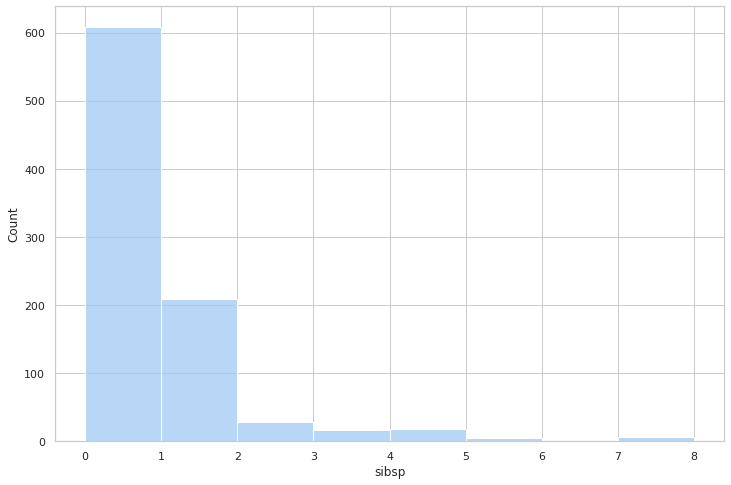

In [22]:
sns.histplot(data=dat, x=sibsp, bins=np.arange(0, dat.sibsp.max() + 1, 1))
display(dat.sibsp.describe(percentiles=[]))
tmp = dat.pivot_table(index=sibsp, values=sex, aggfunc='count')
tmp['%'] = tmp[sex] / tmp[sex].sum()
tmp

Most passengers were travelling without relatives of their generation.

### Parch

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
50%        0.000000
max        6.000000
Name: parch, dtype: float64

,sex,%
parch,,
0,678,0.760943
1,118,0.132435
2,80,0.089787
3,5,0.005612
4,4,0.004489
5,5,0.005612
6,1,0.001122


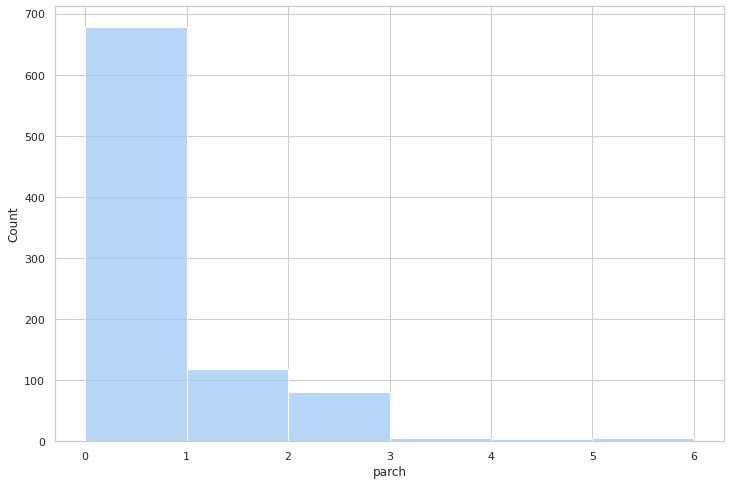

In [23]:
sns.histplot(data=dat, x=parch, bins=np.arange(0, dat.parch.max() + 1, 1))
display(dat.parch.describe(percentiles=[]))
tmp = dat.pivot_table(index=parch, values=sex, aggfunc='count')
tmp['%'] = tmp[sex] / tmp[sex].sum()
tmp

And again - most were without relatives of older/younger generation.

### Ticket

In [24]:
len(dat.ticket.unique()) / len(dat.ticket)

0.7643097643097643

Not all tickets are unique. It seems tickets were bought for entige groups of people. Let's check it.

In [25]:
tmp = dat.sort_values(by=ticket)
tmp = tmp[tmp[ticket].duplicated(keep=False)]
tmp.head(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,Southampton,Maioni,1.0,miss,NaN
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,Southampton,Cherry,1.0,miss,NaN
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,Southampton,Rothes,1.0,ms.,NaN
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,Southampton,Taussig,3.0,mr.,NaN
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,Southampton,Taussig,3.0,mrs.,NaN
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,Southampton,Taussig,3.0,miss,NaN
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,Southampton,Porter,1.0,mr.,NaN
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,Southampton,Clifford,1.0,mr.,NaN
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,Cherbourg,Hippach,2.0,mrs.,NaN
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,Cherbourg,Hippach,2.0,miss,NaN


Yep, same ticket usually means same (or ajacent) cabin.

### Fare

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

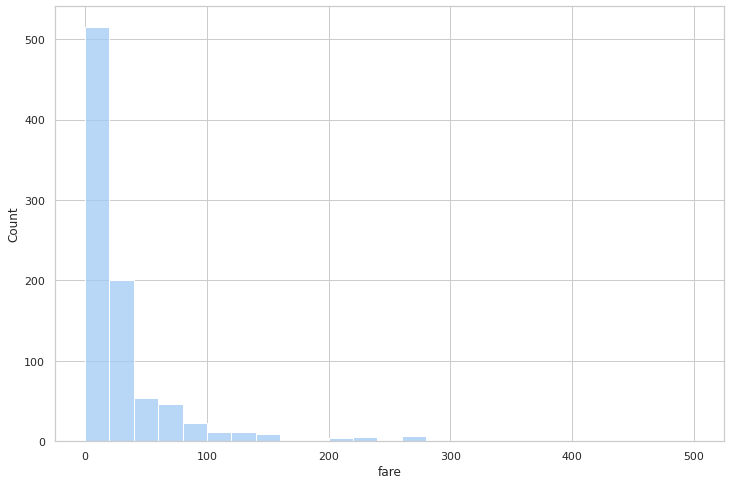

In [26]:
sns.histplot(data=dat, x=fare, bins=np.arange(0, dat.fare.max() + 1, 20))
dat.fare.describe(percentiles=percentiles)

It seems there are very high values and also very low. Let's check them.

In [27]:
dat[dat[fare] > 300].sort_values(by=fare, ascending=False)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,Cherbourg,Ward,1.0,miss,NaN
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,Cherbourg,Cardeza,1.0,mr.,NaN
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,Cherbourg,Lesurer,1.0,mr.,NaN


All other features look fine. Interesting: same ticket all different last names, two men and one single wonam. It seems there is a whole story behind these rows.

Interesting! But no useful info.

Let's look at very small values.

In [28]:
dat[dat[fare] < 6].sort_values(by=fare, ascending=False)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,Southampton,Carlsson,1.0,mr.,NaN
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,Cherbourg,Betros,1.0,mr.,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,Southampton,Johnson,1.0,mr.,NaN
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,Southampton,Reuchlin,1.0,mr.,NaN
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,Southampton,Fry,1.0,mr.,NaN
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,Southampton,Andrews,1.0,mr.,NaN
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,Southampton,Knight,1.0,mr.,NaN
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,Southampton,Watson,1.0,mr.,NaN
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,Southampton,Parr,1.0,mr.,NaN
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,Southampton,Leonard,1.0,mr.,NaN


This is really strange.

- all true zero values embarked in one port - Southampton
- all of them are men without relatives
- almost all of them didn't survive
- there are lots of missing values in there (much more than average 20% of dataset)
- there are people with strange tickets "LINE"
- there are people of all 3 classes in this list. So it seems there were free 1st class tickets. Niiiiice!

These values clearly have different origin than others. As they might mess up our plots, we will remove them.

In [29]:
dat.loc[dat[fare] < 6, fare] = np.nan

### Cabin

Cabin usually is written like "letter + number".

Is seems letter is ship deck and number is cabin number on the deck.

Let's make new columns for these values.

In [30]:
print(f'Missing values {sum(dat.cabin.isna())}, % {round(sum(dat.cabin.isna())/len(dat), 2)}')
print(f'Unique values {len(dat.cabin.unique())}, % of not missing {round(len(dat.cabin.unique()) / len(dat[~dat[cabin].isna()]), 2)}')

dat[dat[cabin].isna()]

Missing values 687, % 0.77
Unique values 148, % of not missing 0.73


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Braund,2.0,mr.,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Heikkinen,1.0,miss,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,Allen,1.0,mr.,NaN
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Queenstown,Moran,1.0,mr.,NaN
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,Southampton,Palsson,4.0,mr.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,Southampton,Sutehall,1.0,mr.,NaN
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Queenstown,Rice,5.0,mrs.,NaN
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,Southampton,Montvila,1.0,mr.,NaN
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,Southampton,Johnston,2.0,miss,"""Carrie"""


In [31]:
dat[deck] = dat.cabin.str.extract(r'([a-zA-Z ]+)')
dat[room] = dat.cabin.str.extract(r'([0-9]+)').astype('float')

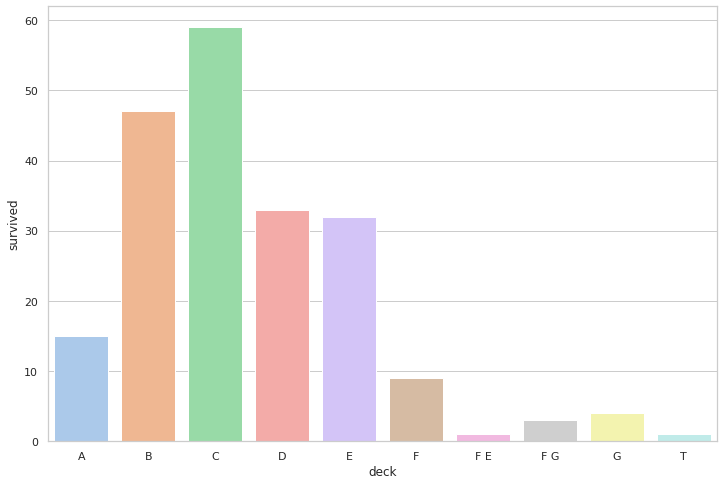

In [32]:
tmp = dat.pivot_table(index=deck, values=survived, aggfunc='count').reset_index()
sns.barplot(data=tmp, x=deck, y=survived);

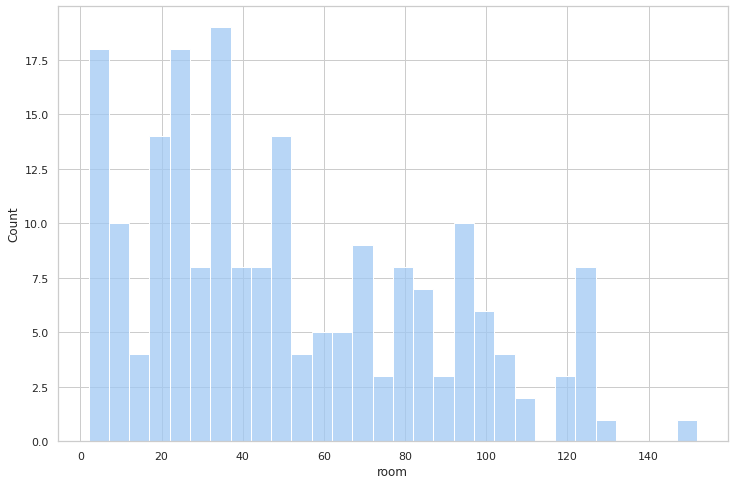

In [33]:
sns.histplot(data=dat, x=room, binwidth=5);

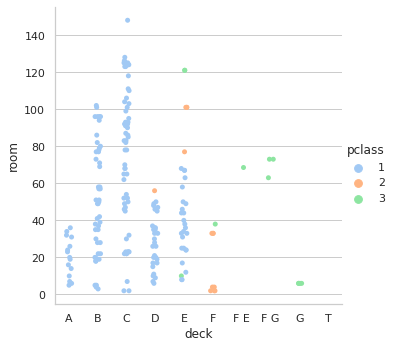

In [34]:
sns.catplot(data=dat.sort_values(by=deck), x=deck, y=room, hue=pclass);

- decks have different number of rooms
- different decks seems to host different passenger classes (although, there is not much statistics here)
- for most passengers of 2-3 class cabins are not specified

### Embarked

,Count,Part_%
Southampton,644.0,0.724409
Cherbourg,168.0,0.188976
Queenstown,77.0,0.086614


Missing values: 2


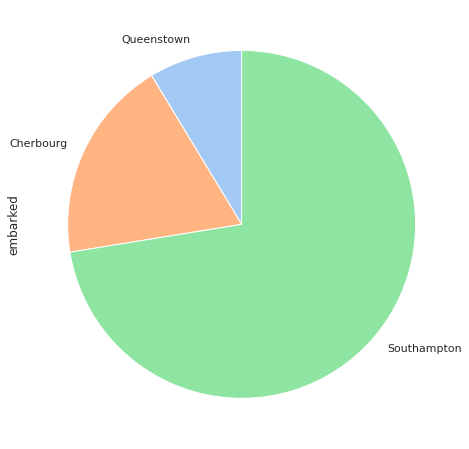

In [35]:
pie_chart(dat, embarked)

In [36]:
dat[dat[embarked].isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,1.0,miss,NaN,B,28.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,1.0,mrs.,NaN,B,28.0


There are two women with no embarked values. They were traveling 1st class with one ticket in one cabin.

In [37]:
tickets = dat[dat[embarked].isna()][ticket]
cabins = dat[dat[embarked].isna()][cabin]

dat[(dat[ticket].isin(tickets)) | (dat[cabin].isin(cabins))]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,1.0,miss,NaN,B,28.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,1.0,mrs.,NaN,B,28.0


There were no other people in their cabin or on their ticket.

Maybe the port is somehow coded into ticket number?

Let's sort rows wo that ticket numbers closest to '113572' are on the top.

In [38]:
dat['tmp'] = dat.ticket.replace('[^0-9]+', '', regex=True).replace('[^0-9]?', '', regex=True).replace('', np.nan).astype('float')
dat['tmp'] = np.abs(dat['tmp'] - 113572)
display(dat.sort_values(by='tmp').head(10))
dat = dat.drop(columns='tmp');

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room,tmp
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN,Stone,1.0,mrs.,NaN,B,28.0,0.0
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,Icard,1.0,miss,NaN,B,28.0,0.0
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,Southampton,Stead,1.0,mr.,NaN,C,87.0,58.0
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,Southampton,Williams-Lambert,1.0,mr.,NaN,C,128.0,62.0
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,Cherbourg,Ostby,1.0,mr.,NaN,B,30.0,63.0
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,Southampton,Bowerman,1.0,miss,NaN,E,33.0,67.0
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,Southampton,Chibnall,1.0,mrs.,NaN,E,33.0,67.0
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,Cherbourg,Widener,1.0,mr.,NaN,C,82.0,69.0
782,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,Southampton,Long,1.0,mr.,NaN,D,6.0,71.0
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,Southampton,Carter,6.0,mr.,NaN,B,96.0,188.0


Same thing but with fare value.

In [39]:
dat['tmp'] = dat.ticket.replace('[^0-9]+', '', regex=True).replace('[^0-9]?', '', regex=True).replace('', np.nan).astype('float')
dat['tmp'] = np.abs(dat[fare] - 80)
display(dat.sort_values(by='tmp').head(10))
dat = dat.drop(columns='tmp');

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room,tmp
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN,Stone,1.0,mrs.,NaN,B,28.0,0.00
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.00,B28,NaN,Icard,1.0,miss,NaN,B,28.0,0.00
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,Southampton,Taussig,3.0,mrs.,NaN,E,67.0,0.35
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,Southampton,Taussig,3.0,mr.,NaN,E,67.0,0.35
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,E68,Southampton,Taussig,3.0,miss,NaN,E,68.0,0.35
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.20,NaN,Cherbourg,Thorne,1.0,mrs.,NaN,NaN,NaN,0.80
789,790,0,1,"Guggenheim, Mr. Benjamin",male,46.0,0,0,PC 17593,79.20,B82 B84,Cherbourg,Guggenheim,1.0,mr.,NaN,B,82.0,0.80
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.20,B41,Cherbourg,Frolicher-Stehli,1.0,mr.,NaN,B,41.0,0.80
139,140,0,1,"Giglio, Mr. Victor",male,24.0,0,0,PC 17593,79.20,B86,Cherbourg,Giglio,1.0,mr.,NaN,B,86.0,0.80
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",female,26.0,0,0,19877,78.85,NaN,Southampton,Barber,1.0,miss,"""Nellie""",NaN,NaN,1.15


Nothing useful. In this analisys missing values will stay.

In ML we should probably fill them with most popular value.

# Group analisys

We looked at each column separately. Now let's look at their combintaions.

We'll start with simplest instrument - pairplot.

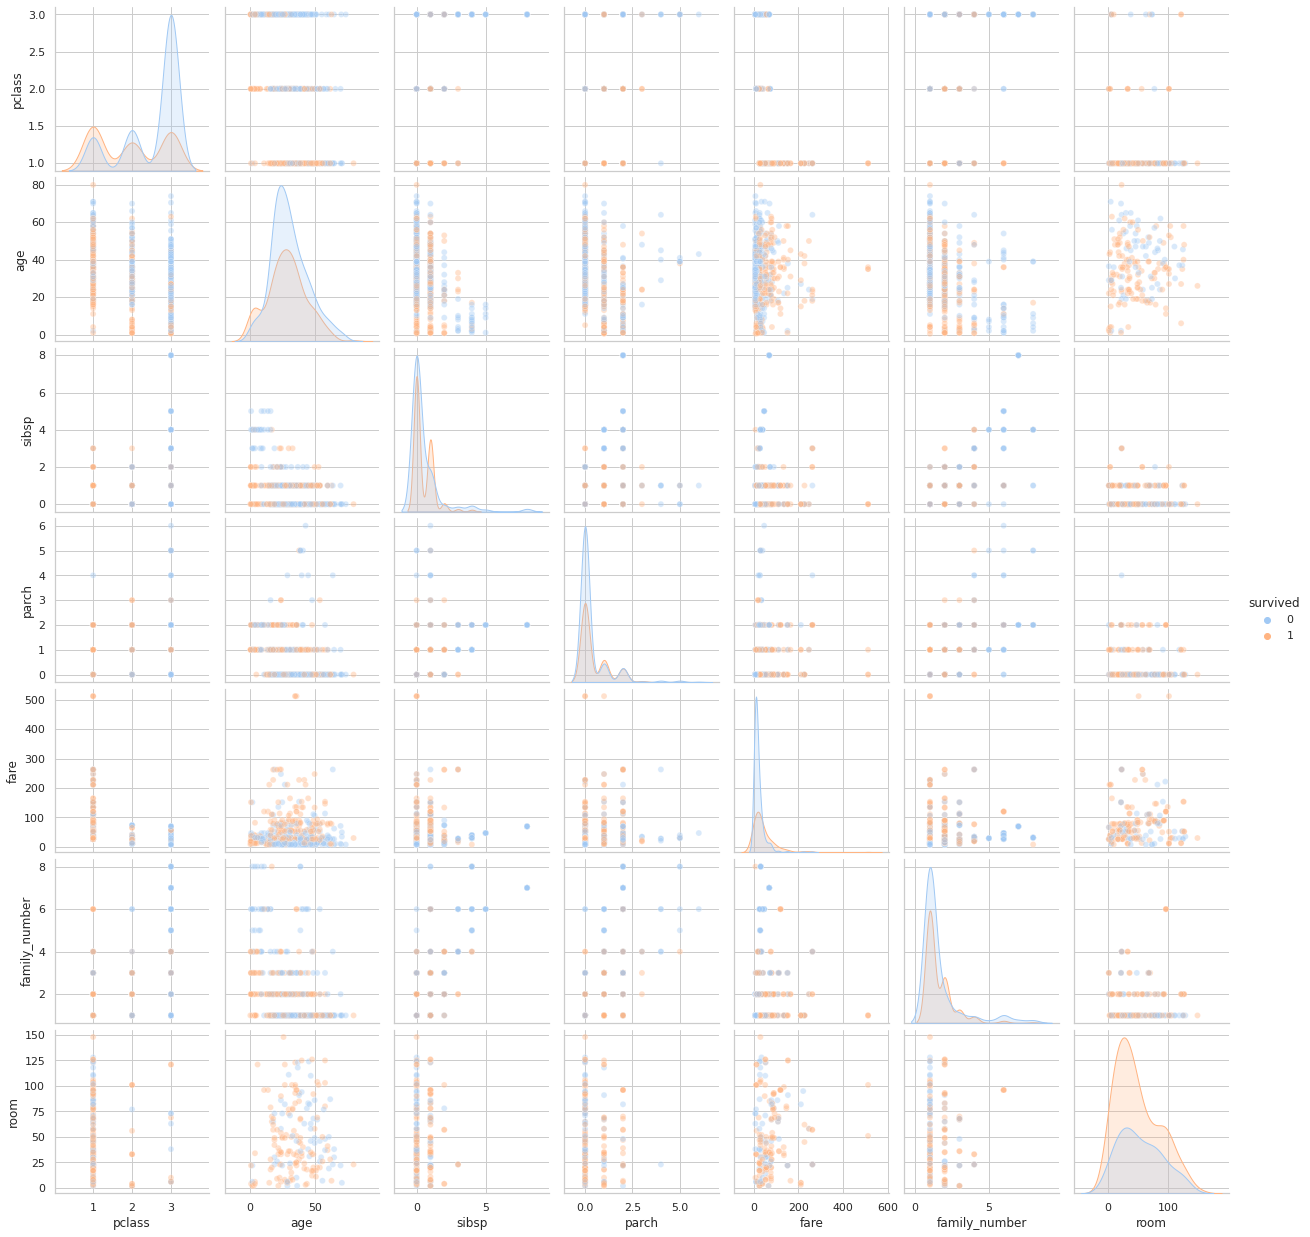

In [40]:
sns.pairplot(data=dat.drop(columns=passengerid), hue=survived, kind='scatter', plot_kws={'alpha': 0.4});

Almost nothing useful. Potentially interesting:
- 1st class have higher survival rate
- 3rd class was travelling in larger families
- 2nd and 3rd class fare was very close
- larger families had more children (low age passengers) in them

### Survival rate in classes and sexes

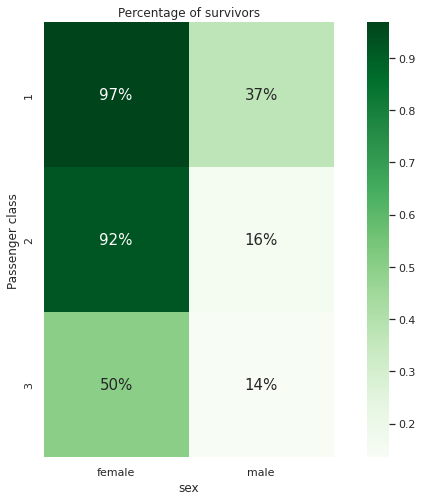

In [41]:
tmp = dat.pivot_table(index=pclass, columns=sex, values=survived)
ax = sns.heatmap(data=tmp,square=True, annot=True, fmt='.0%', annot_kws={'size': 15}, cmap="Greens").set(title='Percentage of survivors', ylabel='Passenger class')

The survival rate for women is much higher.
Also the survival rate for the 1st class is higher.
2nd class is strange - women survival rate is close to 1st class, but men survival rate is close to 3rd.

Let's see how many men and women were in classes.

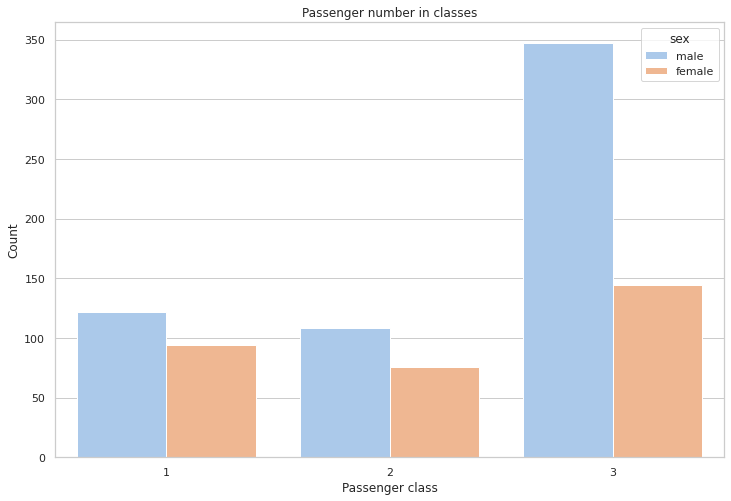

In [42]:
tmp = dat.pivot_table(index=[pclass, sex], values=survived, aggfunc='count').reset_index().sort_values(by=[sex, pclass], ascending=False)
ax = sns.barplot(data=tmp, x=pclass, y=survived, hue=sex).set(title='Passenger number in classes', xlabel='Passenger class', ylabel='Count')

### Let's add age

First - interactive plot in log scale.
Large points for survived=1, small for 0.

In [43]:

fig = px.scatter(dat,
                x=age, y=fare,
                color=dat[pclass].astype('category'),
                size=(dat[survived] + 1) ** 2,
                size_max=10,
                color_discrete_sequence=px.colors.qualitative.Plotly,
                hover_data=dat.columns,
                 hover_name=survived,
                 opacity=0.7,
                 log_y=True,
                 marginal_y='rug',
                 marginal_x='histogram',
                 labels=dict(color = pclass)
                )
fig.update_layout()
#fig.update_layout(legend= {'itemsizing': 'trace'})
fig.show()

Same plot in seaborn.

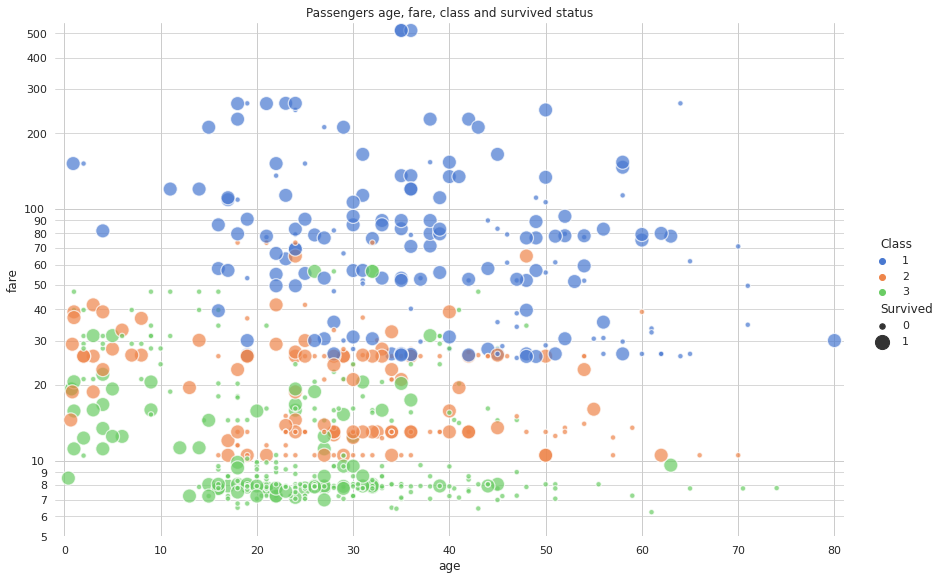

In [44]:
sns.set_style("whitegrid")

g = sns.relplot(data=dat, x=age, y=fare, hue=pclass, size=survived, sizes=(200, 30), palette='muted', alpha=0.7, height=8, aspect=15/10, linewidth=1.25)#, legend=False)
g.set(yscale="log")
g.set(ylim=(5,550))
g.set(xlim=(-1,81))
g.ax.yaxis.grid(True, "minor", linewidth=.75)
g.ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
g.ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
g.set(title='Passengers age, fare, class and survived status');
g._legend.texts[0].set_text('Class')
g._legend.texts[4].set_text('Survived')
g._legend.set_bbox_to_anchor([1.01, 0.5])
sns.despine(left=True, bottom=True)

Great figure: lots of stuff, but very hard to calculate anything.

- each class has a lower ticket price threshold
- most of the 1st class passengers escaped
- most of the 1st class passengers were not children
- most of the children were saved
- prices for children's tickets are higher than for adults
- among the 3rd class, most survivors were under 33
- among 1st class, young people had a little more chances than old, but the tendency is weak

It will be interesting to look at all these trends separately. To do this, we need to look at the distributions:
- age of passengers of each class
- survival depending on age
- prices depending on age

Important note: there is some sort of threshold at 16 years - starting from this age survival rate drops drastically. So maybe a good idea to call age<16 'child' and age>=16 'adult'.

### Age distribution in classes and sexes

Mean age of classes:


sex,female,male
pclass,,
1,34.6,41.3
2,28.7,30.7
3,21.8,26.5


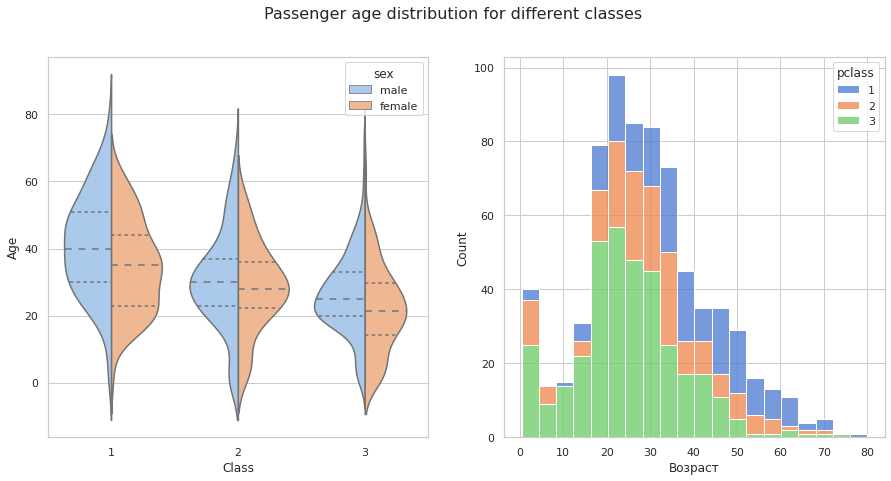

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle("Passenger age distribution for different classes", fontsize=16)
sns.violinplot(ax=ax[0], data=dat, x=pclass, y=age, hue=sex, split=True, inner="quartile", palette='pastel').set(xlabel='Class', ylabel='Age')
sns.histplot(ax=ax[1], data=dat, x=age, hue=pclass, palette='muted', multiple='stack').set(xlabel='Возраст', ylabel='Count')
print('Mean age of classes:')
dat.pivot_table(index=pclass, columns=sex, values=age).round(1)

- on average in all classes, women are several years younger than men
- the more expensive the class, the higher the average age there is and the fewer children
- in 1st class there are very few passengers under 15 years old

### Survival rate distribution in classes, sexes and age groups

Lets plot histograms of age, but include info about class, sex and survival.

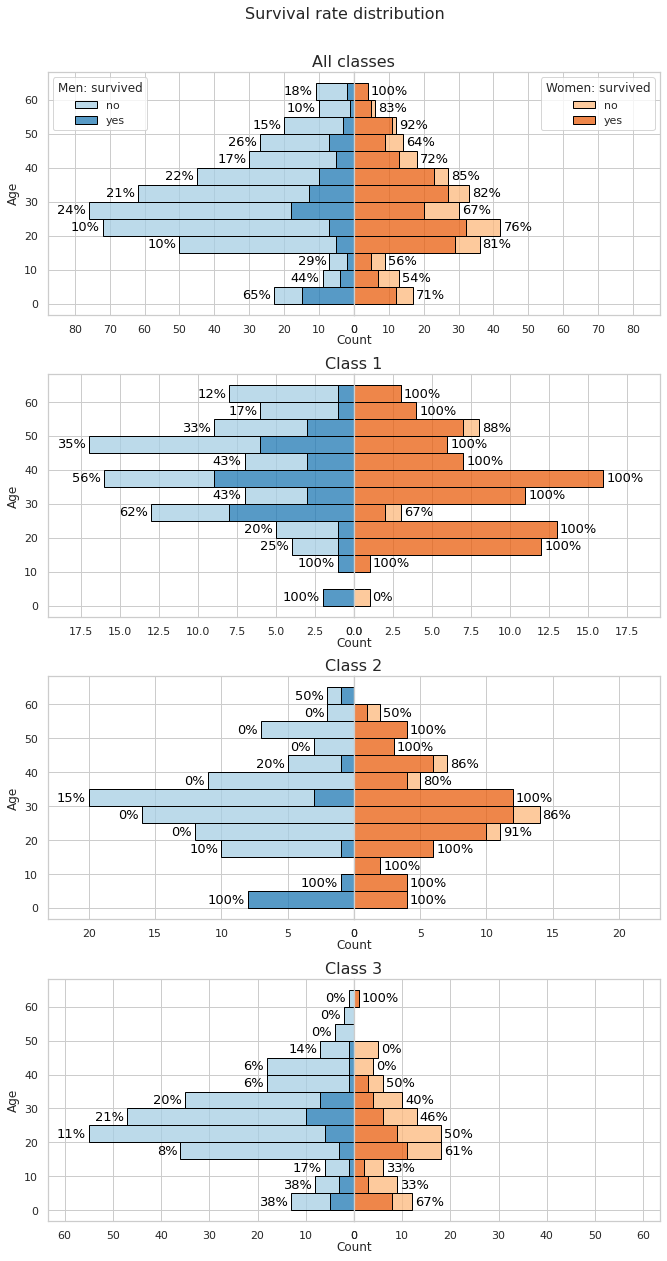

In [46]:
fig, ax = plt.subplots(4, 2, figsize=(10,18))
fig.suptitle("Survival rate distribution", fontsize=16)
plt.tight_layout(pad=3)
plt.subplots_adjust(wspace=0)

max_age = 65
age_step = 4.99999
bins = np.arange(0, max_age + 1, age_step)

for pcl in [0, 1, 2, 3]:
    if pcl == 0:
        tmp_dat = dat.copy()
    else:
        tmp_dat = dat[dat[pclass] == pcl].copy()
    
    ax1 = ax[pcl, 0]
    ax2 = ax[pcl, 1]
    
    g_male = sns.histplot(ax=ax1, data=tmp_dat[(dat.sex == male)].sort_values(by=survived).replace({survived: {0: 'no', 1: 'yes'}}), y=age, hue=survived, palette='Paired', bins=bins, multiple='stack', **dict(edgecolor="black", linewidth=1))
    ax1.set(ylabel='Age', xlabel='')
    ax1.invert_xaxis()
    max_val = max(list(ax1.get_xlim())) * 1.1
    ax1.set(xlim=(max_val, 0))

    g_female = sns.histplot(ax=ax2, data=tmp_dat[(dat.sex == female)].sort_values(by=survived).replace({survived: {0: 'no', 1: 'yes'}}), y=age, hue=survived, palette='Oranges', bins=bins, multiple='stack', **dict(edgecolor="black", linewidth=1))
    ax2.set(yticklabels=[], ylabel='', xlabel='Count')
    if pcl == 0:
        title='All classes'
    else: 
        title='Class {}'.format(pcl)
    ax2.set_title(title, x=0.00, y=1.08, pad=-14, fontsize=16)
    ax2.set(xlim=(0, max_val))
    ax2.xaxis.set_label_coords(.00, -0.08)
    
    if pcl == 0:
        ax1.get_legend().set_title("Men: survived")
        ax2.get_legend().set_title("Women: survived")
    else:
        ax1.legend().set_visible(False)
        ax2.legend().set_visible(False)

    tmp_dat['age_cat'] = pd.cut(tmp_dat[age], bins=bins, labels=bins[:-1])
    tmp = tmp_dat[~dat.age.isna()].pivot_table(index='age_cat', columns=sex, values=survived, aggfunc=['mean', 'count'])
    tmp.columns = [i[0] + '_' + i[1] if i[0] != 'mean' else i[1] for i in tmp.columns]
    tmp_dat = tmp_dat.drop(columns='age_cat')

    for i, row in tmp.iterrows():
        if row[male] >= 0:
            ax1.text(row['count_male'] + max_val / 100, i + age_step / 2, '{:.0%}'.format(row[male]), fontdict=dict(fontsize=13, color='black', verticalalignment='center', horizontalalignment='right'))
        if row[female] >= 0:
            ax2.text(row['count_female'] + max_val / 100, i + age_step / 2, '{:.0%}'.format(row[female]), fontdict=dict(fontsize=13, color='black', verticalalignment='center', horizontalalignment='left'))
            
plt.savefig('Titanic_survival.png')

Also let's look at the same dependence with smaller age step (2 years).

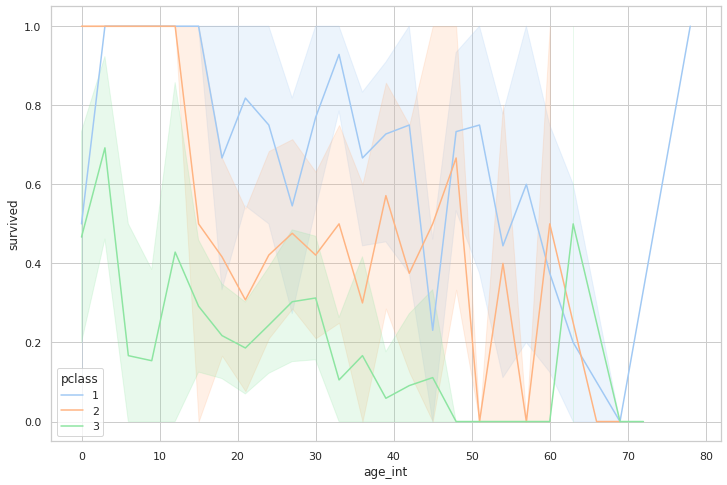

In [47]:
tmp = dat[dat[age].notna()]
tmp['age_int'] = (tmp[age] / 3).astype('int16') * 3
sns.lineplot(data=tmp, x='age_int', y=survived, hue=pclass, palette='pastel');

In general for all classes:
- in every age group, women were more likely to be saved
- among children, this difference is minimal
- on average, children are more likely to be saved than adults
- young men (15-25 years old) and old men survived least of all (although there are not enough statistics there)
- Most of all women aged over 50 survived

Analysis by class:
- in classes 1 and 2, the vast majority of women were saved
- in classes 1 and 2 there were very few children and a quite a lot of old people
- there were very few people over 50 in class 3
- in the 2nd and 3rd classes, very few men were saved

### Fare for different classes, sexes and ages

Fare of classes:


min  median  mean  max
pclass sex                           
1      female   26      83   106  512
       male     26      50    71  512
2      female   10      22    22   65
       male     10      13    21   74
3      female    7      12    16   70
       male      6       8    13   70

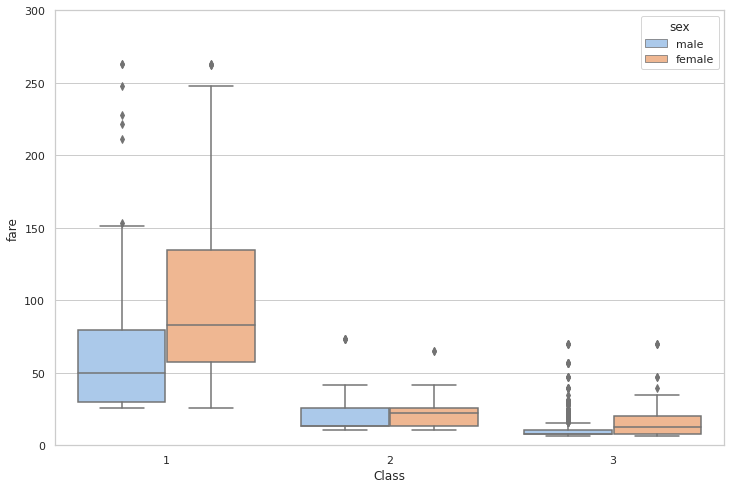

In [48]:
sns.boxplot(data=dat, x=pclass, y=fare, hue=sex, palette='pastel').set(xlabel='Class', ylim=(0,300))
print('Fare of classes:')
tmp = dat.pivot_table(index=[pclass, sex], values=fare, aggfunc=['min', 'median', 'mean', 'max']).round(0).astype('int')
tmp.columns = [i[0] for i in tmp.columns]
tmp

Surprisingly, female tickets are consistently more expensive than male tickets.

And only the 2nd class, as usual, breaks the pattern.

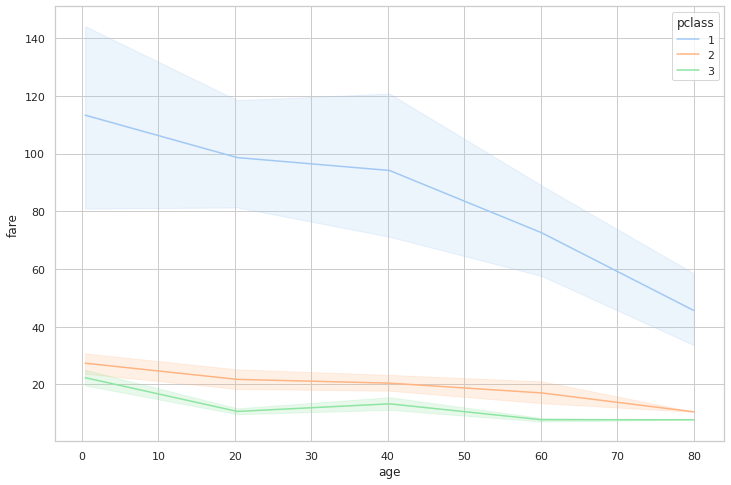

In [49]:
dat['age_cat'] = pd.cut(dat[age], 5, labels=np.linspace(dat[age].min(), dat[age].max(), 5))
sns.lineplot(data=dat, x='age_cat', y=fare, hue=pclass, palette='pastel').set(xlabel='age')
dat = dat.drop(columns='age_cat')

Indeed, with increasing age, the price of tickets drops in all classes. How is it possible?

Another question: did the fare value influence survival chance? We've seen that survival greatly depends on class, sex and age, so in this plot we will consider only adults and count sex and class separately.

Hypothesys is: survived passengers of those groups payed more than dead passengers of the same groups.

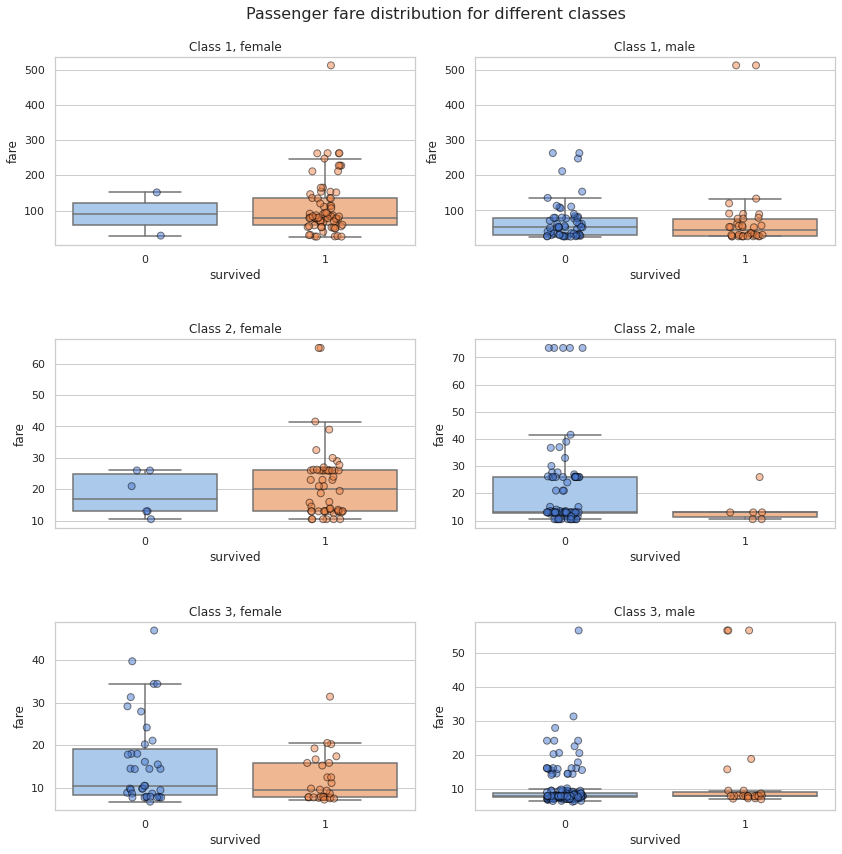

In [50]:
rows = len(dat.pclass.unique())
cols = len(dat.sex.unique())

fig, ax = plt.subplots(rows, cols, figsize=(12,12))
fig.suptitle("Passenger fare distribution for different classes", fontsize=16)
plt.tight_layout(pad=2)
plt.subplots_adjust(hspace=0.5)

for i, sex_val in enumerate(sorted(dat.sex.unique())):
    for j, class_val in enumerate(sorted(dat.pclass.unique())):
        g = sns.boxplot(ax=ax[j, i],
            data=dat[(dat.pclass == class_val) & (dat.sex == sex_val) & (dat.age >= 18)],
            x=survived, y=fare, palette='pastel',
            showfliers = False)
        g.set(title=f'Class {class_val}, {sex_val}')
        
        sns.stripplot(ax=ax[j, i],
            data=dat[(dat.pclass == class_val) & (dat.sex == sex_val) & (dat.age >= 18)],
            x=survived, y=fare, palette='muted', s=7, jitter=0.1, alpha=0.5, **dict(edgecolor="black", linewidth=1))

Well, there there seem to be no explicit correlation between survival and fare.

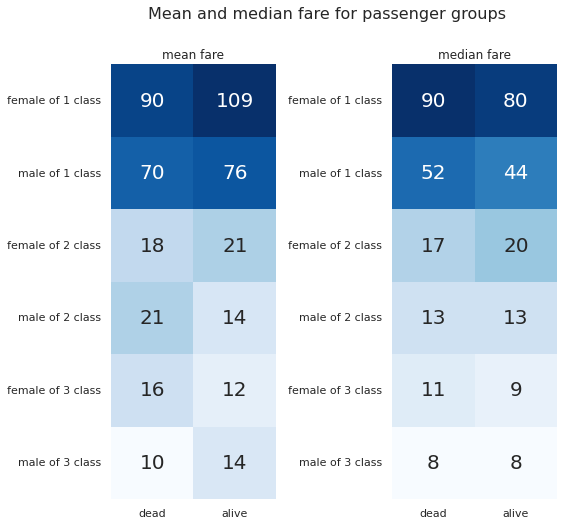

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(8,8))
fig.suptitle("Mean and median fare for passenger groups", fontsize=16)
plt.subplots_adjust(wspace=0.7)

tmp = dat[dat.age >= 18].pivot_table(index=[pclass, sex], values=fare, columns=survived, aggfunc=['mean', 'median'])#.reset_index()
tmp.columns = ['mean: dead', 'mean: alive', 'median: dead', 'median: alive']
tmp = tmp.reset_index()
tmp['group'] = tmp[sex] + ' of ' + tmp[pclass].apply(str) + ' class' 
tmp = tmp.set_index('group')
tmp = tmp[['mean: dead', 'mean: alive', 'median: dead', 'median: alive']]
vmin = tmp.min().min()
vmax = tmp.max().max()

for i, group_value in enumerate([['mean: dead', 'mean: alive'], ['median: dead', 'median: alive']]):
    g = sns.heatmap(ax=ax[i],
                data=tmp[group_value].rename(columns={group_value[0]: 'dead', group_value[1]: 'alive'}), 
                annot=True, 
                fmt='.0f', 
                annot_kws={'size': 20},
                cmap='Blues', 
                norm=LogNorm(),
                cbar=False,
                vmin=vmin, vmax=vmax,
                cbar_kws={"format": mticker.ScalarFormatter()})
    g.set(title=group_value[0].split(':')[0] + ' fare')
    g.set(ylabel='')

So we see that there is no explicit correlation between fare and survival (except for the fare => pclass => survival logic).

### Decks and rooms

First, let's see in which class all those missing values are. Maybe all in 3rd?

,total,missing,present,present_%,missing_%
pclass,,,,,
1,216,40,176,0.81,0.19
2,184,168,16,0.09,0.91
3,491,479,12,0.02,0.98


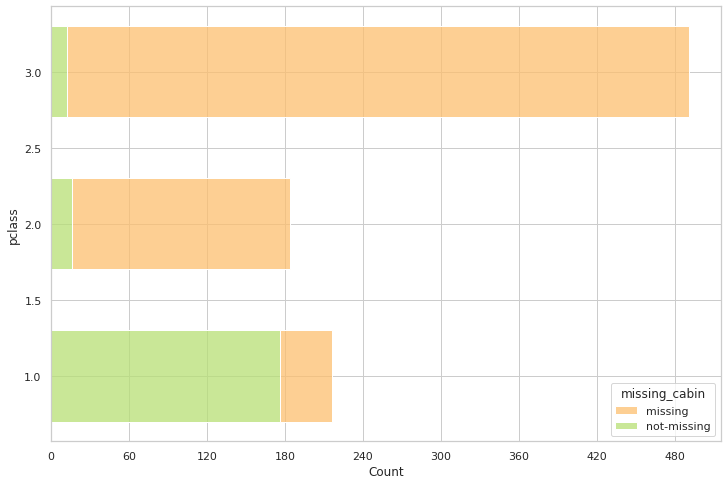

In [52]:
dat['missing_cabin'] = 'not-missing'
dat.loc[dat.cabin.isna(), 'missing_cabin'] = 'missing'

ax = sns.histplot(data=dat, y=pclass, hue='missing_cabin', multiple='stack', palette='RdYlGn', bins=np.arange(0.5, 3.6, 1), shrink=.6)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

dat = dat.drop(columns='missing_cabin')

tmp = dat.copy().fillna('temp_123')
tmp = tmp.pivot_table(index=pclass, values=cabin, aggfunc=['count', lambda x: x[x == 'temp_123'].count()])
tmp.columns = ['total', 'missing']
tmp['present'] = tmp.total - tmp.missing
for i in ['present', 'missing']:
    tmp[i + '_%'] = (tmp[i] / tmp.total).round(2)
tmp

There are missing values in all 3 classes.

In 2nd and 3rd more than 90% of cabin values are missing, so there seems to be no point in analyzing them.

Let's see if there are passengers with some cabin value that wasn't successfully parsed into deck + room.

In [53]:
display(dat[((dat[deck].isna()) | (dat[room].isna())) & (~dat[cabin].isna())])
print('\nPassengers on deck T:')
dat[dat.deck == 'T']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,Cherbourg,Levy,1.0,mr.,NaN,D,NaN
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,Southampton,Ball,1.0,mrs.,NaN,D,NaN
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,Southampton,Blackwell,1.0,mr.,NaN,T,NaN
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,Cherbourg,Jerwan,1.0,mrs.,NaN,D,NaN



Passengers on deck T:


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_name,family_number,marital_status,nickname,deck,room
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,Southampton,Blackwell,1.0,mr.,NaN,T,NaN


There are 4 passengers with some cabin parsing problems. 1st and 2nd classes. Travelling without family.

As was shown earlier, there are lots of passengers on deck D.

And here we see, that there is only one passenger on deck T.

As we have already seen, passenger class and sex was very important for survival. We have decided to analyze only class 1 rooms.

Let's look at passengers distribution between decks and rooms.

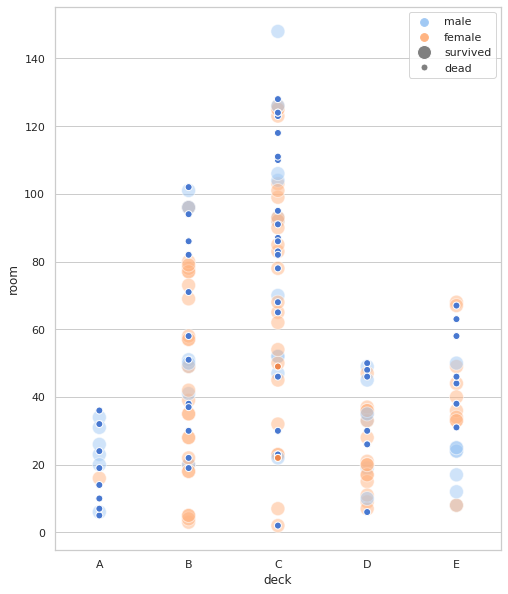

In [54]:
fig = plt.figure(figsize=(8,10))
tmp = dat[(dat.pclass == 1) & (dat.deck != 'T')].sort_values(by=[deck]).sort_values(by=[deck])
g1 = sns.stripplot(data=tmp[tmp.survived == 1],
            x=deck, y=room, hue=sex, 
            s=14,
            palette='pastel', alpha=0.5, **dict(edgecolor="white", linewidth=1), jitter=0)
g2 = sns.stripplot(data=tmp[tmp.survived == 0],
            x=deck, y=room, hue=sex, 
            s=7, 
            palette='muted', alpha=1, **dict(edgecolor="white", linewidth=1), jitter=0)
g.set(title='Passenger rooms distribution on decks for class 1');

handles, labels = g1.get_legend_handles_labels()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='survived',
                          markerfacecolor='gray', markersize=14),
                   Line2D([0], [0], marker='o', color='w', label='dead',
                          markerfacecolor='gray', markersize=7)]

plt.legend(handles=handles[0:2] + legend_elements);

- decks have different number of rooms. Maybe their lenght is different, or maybe room size is different
- somehow almos all passengers of deck A are men
- there seems to be no pattern in suvival in different rooms, so room number probably doesn't matter

Now let's look at numbers.

mean            count     
sex        female      male female male
deck                                   
A        1.000000  0.428571      1   14
B        1.000000  0.400000     27   20
C        0.888889  0.343750     27   32
D        1.000000  0.461538     16   13
E        1.000000  0.533333     10   15
unknown  1.000000  0.214286     13   28

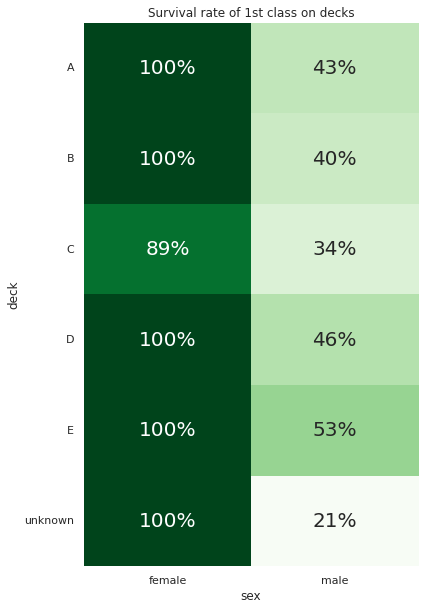

In [55]:
fig = plt.figure(figsize=(6,10))
tmp = dat[(dat.pclass == 1)]
#tmp = tmp[tmp.age >= 18]
tmp.loc[tmp.deck == 'T', deck] = np.nan
tmp[deck] = tmp[deck].fillna('unknown')
tmp1 = tmp.pivot_table(index=deck, columns=sex, values=survived)

sns.heatmap(data=tmp1,
                annot=True, fmt='.0%', annot_kws={'size': 20},
                cmap='Greens', 
                cbar=False).set(title='Survival rate of 1st class on decks')
plt.yticks(rotation=0)     

tmp.pivot_table(index=deck, columns=sex, values=survived, aggfunc=['mean', 'count'])

There seems to be no real effect of deck number on survival rate.

But! As we've seen earlier there are a lot of missing values in cabin (and therefore deck) column. In 1st class there are 20% missing values. And in this unknown category survival rate of men is much lower.

Let's look at fare for cabins on different decks. Also we've seen earlier that women tend to pay more, so we'll split data on men and women.

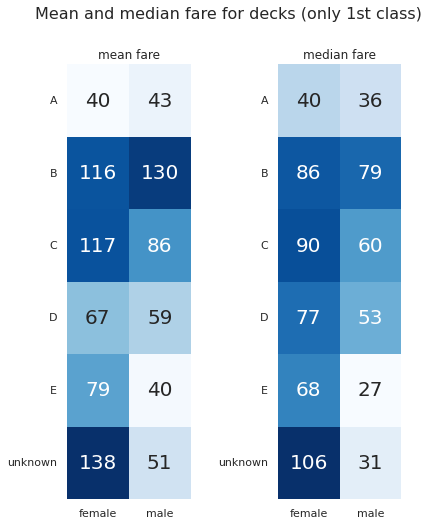

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(6,8))
fig.suptitle("Mean and median fare for decks (only 1st class)", fontsize=16)
plt.subplots_adjust(wspace=0.7)

tmp = dat[(dat.pclass == 1)]
tmp.loc[tmp.deck == 'T', deck] = np.nan
tmp[deck] = tmp[deck].fillna('unknown')
tmp = tmp.pivot_table(index=deck, values=fare, columns=sex, aggfunc=['mean', 'median'])
tmp.columns = ['mean: female', 'mean: male', 'median: female', 'median: male']
vmin = tmp.min().min()
vmax = tmp.max().max()

for i, group_value in enumerate([['mean: female', 'mean: male'], ['median: female', 'median: male']]):
    g = sns.heatmap(ax=ax[i],
                data=tmp[group_value].rename(columns={group_value[0]: 'female', group_value[1]: 'male'}), 
                annot=True, 
                fmt='.0f', 
                annot_kws={'size': 20},
                cmap='Blues', 
                norm=LogNorm(),
                cbar=False,
                vmin=vmin, vmax=vmax,
                cbar_kws={"format": mticker.ScalarFormatter()})
    g.set(title=group_value[0].split(':')[0] + ' fare')
    g.set(ylabel='')
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)#, fontsize = 8)   

- women almost always pay more than men
- mean price vary very much
- decks B and C are most expensive
- deck A is cheapest
- unknown cabins have much haigher price. Strange... As we've seen earlier, they have much lower survival rate for men.

### Ports of embarkation

First let's look at passenger classes from different ports

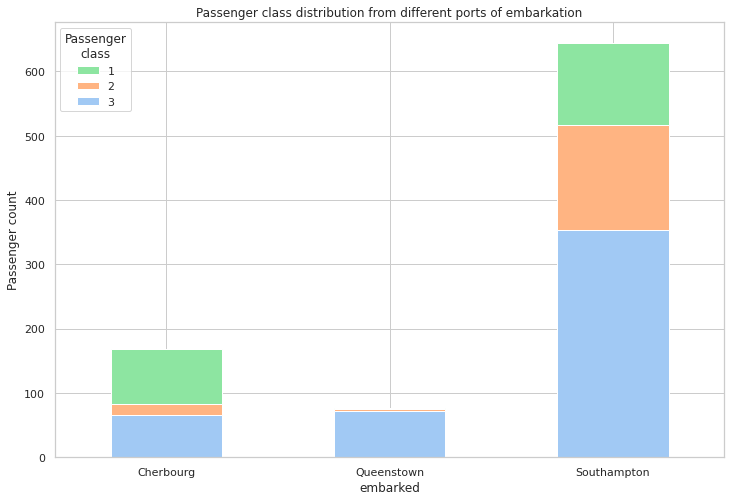

In [57]:
tmp = dat.pivot_table(index=embarked, columns=pclass, values=survived, aggfunc='count')
tmp = tmp.reindex(sorted(tmp.columns, reverse=True), axis=1)

g = tmp.plot(kind='bar', stacked=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 0)
g.set(ylabel='Passenger count')
g.set(title='Passenger class distribution from different ports of embarkation')

handles, labels = g.get_legend_handles_labels()

l = plt.legend(handles=handles[-1::-1], labels=labels[-1::-1], title='Passenger\nclass');
l.get_title().set_ha("center")

There is huge difference in classes from different ports. Almost everyone from Queenstown were 3rd class. And half of people from Cherbourg were 1st class.

The survival rate from different ports will be different, since, as we know, it primarily depends on pclass and sex.

Lets see at the same data differenty: survival rates for different sex/pclass/port.

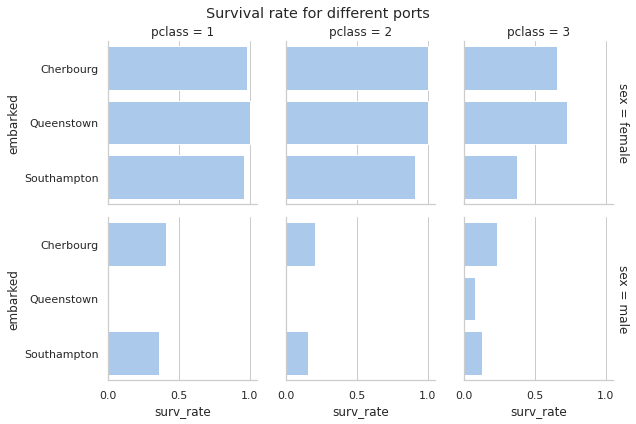

In [58]:
tmp = dat.pivot_table(index=[embarked, pclass, sex], values=survived, aggfunc=['mean', 'count'])
tmp.columns = ['surv_rate', 'survived']
tmp = tmp.reset_index()
g = sns.FacetGrid(tmp, row=sex, col=pclass, margin_titles=True)
g.map(sns.barplot, 'surv_rate', embarked)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survival rate for different ports');

Ok, so we see that survival rate for pclass 1 and 2 almost doesn't depend on the port. For pclass 3 there is some kind of dependence. But we should remember that most of the passengers boarded in S, so for other ports there is much less observations.

### Family size

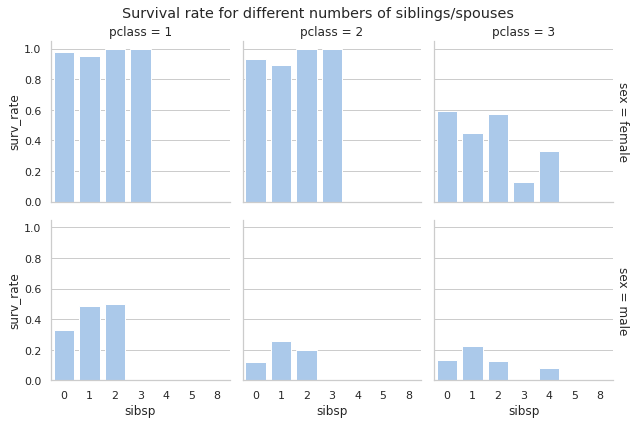

In [59]:
tmp = dat.pivot_table(index=[sibsp, pclass, sex], values=survived, aggfunc=['mean', 'count'])
tmp.columns = ['surv_rate', 'survived']
tmp = tmp.reset_index()
g = sns.FacetGrid(tmp, row=sex, col=pclass, margin_titles=True)
g.map(sns.barplot, sibsp, 'surv_rate')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survival rate for different numbers of siblings/spouses');

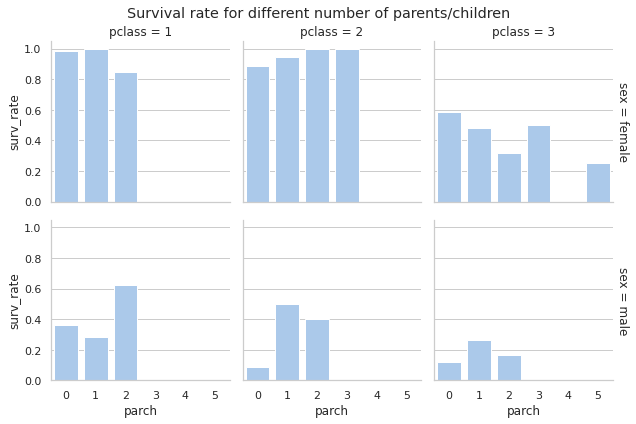

In [60]:
tmp = dat.pivot_table(index=[parch, pclass, sex], values=survived, aggfunc=['mean', 'count'])
tmp.columns = ['surv_rate', 'survived']
tmp = tmp.reset_index()
g = sns.FacetGrid(tmp, row=sex, col=pclass, margin_titles=True)
g.map(sns.barplot, parch, 'surv_rate')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survival rate for different number of parents/children');

And again there is no explicit trends, but we can see some sort of dependence and it looks similar for these two features: subsp and parch.

Lets sum them into a new feature "family_size'.

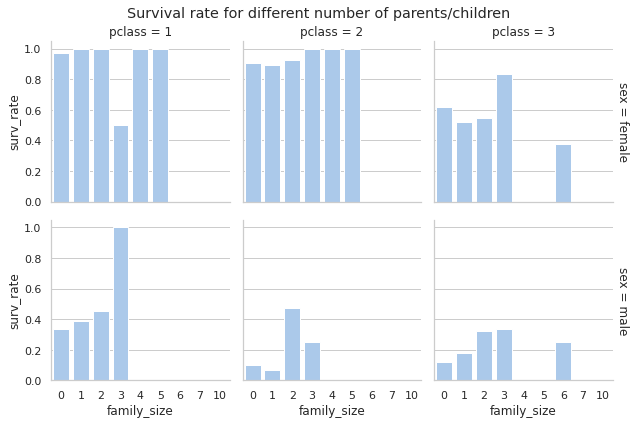

In [61]:
dat['family_size'] = dat[parch] + dat[sibsp]
tmp = dat.pivot_table(index=[family_size, pclass, sex], values=survived, aggfunc=['mean', 'count'])
tmp.columns = ['surv_rate', 'survived']
tmp = tmp.reset_index()
g = sns.FacetGrid(tmp, row=sex, col=pclass, margin_titles=True)
g.map(sns.barplot, family_size, 'surv_rate')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survival rate for different number of parents/children');

This feature could be useful.

# EDA results

Lets sum up our discoveries concerning importance of given features:

- PassengerId - useless
- Pclass - super useful. Shoud be categorical, not numerical or even ranged in my opinion
- Name - full name including some titles. There is lots of information there, but it doesn't seem to have any predictive power
- Sex - super useful (pun intended)
- Age - useful, especially for children (higher survival rate). Problem: lots of missing values! Probably should be converted into categories like: child, adult, unknown
- SibSp + Parch - somewhat useful, not explicit. Maybe shoud be aggregated into one feature 'family_size'
- Ticket - seems to be useless
- Fare - maybe useful, maybe not. Should be tested
- Cabin - lots of missimg values. Consists of deck (letter) and room number. Room number is useless, deck letter probably can be useful
- Embarked - maybe useful, maybe not. Should be tested. There are a few missing values, can be safely filled with most popular value

# Missing values handling

There are 3 columns with missing values (and strategies for hadling):
- embarked - fill with most popular values
- cabin - fill deck number with 'unknown', ignore room number
- age - one of the most important features, should be treated with care. There seems to be no way to fill it with adequate integers, so it might be a good idea to make age feature categorical

# Classification algorithm

First lets prepare the data. Since we might want to do this a few times, we'll define a fuction for that and test it right away.

The fuction will create a single dataframe for train and test for simultaneous manipulations.

In [62]:
test_pass_id = False
def load_dataset(verbose=False, fare_low_limit=6, fare_high_limit=200, children_cats=1, age_float=False):
    global test_pass_id
    train = pd.read_csv('/kaggle/input/titanic/train.csv')
    train.columns = [i.lower() for i in train.columns]
    test = pd.read_csv('/kaggle/input/titanic/test.csv')
    test.columns = [i.lower() for i in test.columns]
    test_pass_id = test['passengerid']
    dataset = pd.concat([train, test])
    dataset[deck] = dataset.cabin.str.extract(r'([a-zA-Z ]+)')
    dataset[deck] = dataset[deck].fillna('Unknown')
    dataset[family_size] = dataset[sibsp] + dataset[parch]
    dataset[embarked] = dataset[embarked].fillna(dataset[embarked].value_counts().index[0])
    
    dataset['age_float'] = dataset[age]
    dataset[age] = 'unknown'
    if children_cats == 1:
        dataset.loc[dataset['age_float'] < 16, age] = 'child'
    if children_cats == 2:
        dataset.loc[dataset['age_float'] < 16, age] = 'child'
        dataset.loc[dataset['age_float'] < 10, age] = 'small child'
    dataset.loc[dataset['age_float'] >= 16, age] = 'adult'

    dataset[dataset[fare] < fare_low_limit][fare] = np.nan
    fare_to_fill = dataset.groupby([pclass, sex])[fare].transform('median')
    dataset[fare] = dataset[fare].fillna(fare_to_fill)
    dataset.loc[dataset[fare] > fare_high_limit, fare] = fare_high_limit

    dataset = dataset.drop(columns=[name, ticket, cabin, passengerid, sibsp, parch])
    if age_float:
        dataset = dataset.drop(columns=[age])
    else:
        dataset = dataset.drop(columns=['age_float'])
    cat_list = [pclass, sex, age, embarked, deck]
    for i in [a for a in cat_list if a in dataset.columns.tolist()]:
        dataset[i] = dataset[i].astype('O')
   
    if verbose:
        display(dataset)
        dataset.info()
    return dataset

a = load_dataset(verbose=True)

,survived,pclass,sex,age,fare,embarked,deck,family_size
0,0.0,3,male,adult,7.2500,S,Unknown,1
1,1.0,1,female,adult,71.2833,C,C,1
2,1.0,3,female,adult,7.9250,S,Unknown,0
3,1.0,1,female,adult,53.1000,S,C,1
4,0.0,3,male,adult,8.0500,S,Unknown,0
...,...,...,...,...,...,...,...,...
413,NaN,3,male,unknown,8.0500,S,Unknown,0
414,NaN,1,female,adult,108.9000,C,C,0
415,NaN,3,male,adult,7.2500,S,Unknown,0
416,NaN,3,male,unknown,8.0500,S,Unknown,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    float64
 1   pclass       1309 non-null   object 
 2   sex          1309 non-null   object 
 3   age          1309 non-null   object 
 4   fare         1309 non-null   float64
 5   embarked     1309 non-null   object 
 6   deck         1309 non-null   object 
 7   family_size  1309 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 92.0+ KB


Now lets prepare functions for catboost learning with optuna.

In [63]:
def objective(trial, train, n_splits=6, test_size=0.2, random_state=1, random_state_bonus=1):
    
    # indices of train dataframe columns with 'object' type
    cat_features = []
    for i, t in enumerate(train[features].dtypes):
        cond = ('object' in str(t))
        if cond: cat_features.append(i)
    cat_features = tuple(cat_features)
    
    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "objective": trial.suggest_categorical("objective", ["CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        'learning_rate': trial.suggest_float("learning_rate", 0.02, 0.95),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.00001, 3000),
        "depth": trial.suggest_int("depth", 6, 12),
        'iterations': trial.suggest_int("iterations", 200, 1000),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
        #"used_ram_limit": "3gb",
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        'cat_features': trial.suggest_categorical('cat_features', [cat_features]),
        'random_seed': trial.suggest_categorical("random_seed", [random_state + random_state_bonus]),
        'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds', [20]),
    }

    model = cb.CatBoostClassifier(**param)

    # we'll use standart sklearn cross_val_score function instead of catboost cv
    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    mean_cv_score = model_selection.cross_val_score(model, 
                                                    train[features],
                                                    train[targets], 
                                                    cv=cv, n_jobs=-1, scoring='accuracy', error_score="raise")
    # requiered for stopping calculations for 'bad' hyperparameters
    if trial.should_prune():
        raise optuna.TrialPruned()
            
    return mean_cv_score.mean()


def one_study(dataset, result, n_trials=10000, timeout=60, plots=False, n_splits=6, test_size=0.2, random_state=1, random_state_bonus=1, text_explanation='_'):
    # prepare features and targets
    train_df = dataset[dataset[survived].notna()]
    test_df = dataset[dataset[survived].isna()]
    train = {}
    test = {}
    train[features] = train_df.drop(columns=survived)
    train[targets] = train_df[survived].astype('category')
    test[features] = test_df.drop(columns=survived)

    # optuna magic
    study = optuna.create_study(direction="maximize", study_name='Catboost optimizer',
                               pruner=optuna.pruners.SuccessiveHalvingPruner(),
                               )
    study.optimize(lambda trial: objective(trial, train, n_splits=n_splits, test_size=test_size, random_state=random_state, random_state_bonus=random_state_bonus), 
                   n_trials=n_trials, 
                   timeout=timeout,
                   show_progress_bar=True
                  )

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    parameters = trial.params
    print("  Value: {}".format(trial.value))
    print("  Params: ", parameters)

    if plots:
        # select only varying parameters for plotting
        full_param_series_list = []
        for i in range(len(study.trials)):
            full_param_series_list.append(pd.Series(study.trials[i].params))
        param_df = pd.DataFrame(full_param_series_list)
        interestring_params = []
        for c in param_df.columns.tolist():
            if len(param_df[c].unique().tolist()) > 1:
                interestring_params.append(c)
        
        # all good plots
        fig_list = [
            optuna.visualization.plot_optimization_history(study),
            optuna.visualization.plot_slice(study, params=interestring_params),
            optuna.visualization.plot_parallel_coordinate(study, params=interestring_params),
            optuna.visualization.plot_param_importances(study, params=interestring_params),
            optuna.visualization.plot_param_importances(
                study, target=lambda t: t.duration.total_seconds(), target_name="duration", params=interestring_params
            )
        ]
        # show them and set adequate size
        for fig in fig_list:
            fig.update_layout(width=1000)
            fig.show()
    
    model = cb.CatBoostClassifier(**parameters)
    pool = cb.Pool(data=train[features], label=train[targets], cat_features=parameters['cat_features'])
    model.fit(pool)
    feature_importances = model.get_feature_importance(data=pool,
                                 type='PredictionValuesChange',
                                prettified=True,
                                )
    print(feature_importances)
    
    # save all important stuff as a new line in result-dataframe
    result.loc[len(result)]=[trial.value, dataset, text_explanation, parameters]
    return study

We'll collect best results in a single dataframe.

In [64]:
result = pd.DataFrame(columns=['cv_score', 'dataset', 'text_explanation', 'best_params'])
n_trials = 50
timeout = 12000

Now let's try to use all useful (and somewhat useful) features and see cv-score.

In [65]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

dataset = load_dataset()

s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              plots=True, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='age_cat')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8296089385474862
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.054248003301417595, 'learning_rate': 0.3213416694117123, 'l2_leaf_reg': 1028.4801179144768, 'depth': 6, 'iterations': 335, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 4, 5), 'random_seed': 12346, 'early_stopping_rounds': 20}


    Feature Id  Importances
0          sex    58.563650
1       pclass    17.280769
2         fare    10.147281
3  family_size     5.353671
4     embarked     3.223051
5          age     2.997829
6         deck     2.433749


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [66]:
dataset = load_dataset(age_float=True)

s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='age_float')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.835195530726257
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03713798137484743, 'learning_rate': 0.689332401102841, 'l2_leaf_reg': 1439.1172502597963, 'depth': 10, 'iterations': 930, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 3, 4), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    68.976451
1         deck     7.212665
2         fare     6.914062
3       pclass     6.837036
4    age_float     4.595973
5  family_size     3.355242
6     embarked     2.108570


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [67]:
dataset = load_dataset()
dataset = dataset.drop(columns=[fare])

s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_fare')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8286778398510242
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.023269693584469658, 'learning_rate': 0.34654159508192794, 'l2_leaf_reg': 981.1556933395688, 'depth': 7, 'iterations': 746, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 3, 4), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    60.880339
1       pclass    22.659726
2         deck     6.287454
3  family_size     5.003933
4     embarked     3.629639
5          age     1.538909


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [68]:
dataset = load_dataset()
dataset = dataset.drop(columns=[embarked])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_embark')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8277467411545625
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08509764191943629, 'learning_rate': 0.854936100691625, 'l2_leaf_reg': 2798.4527003427997, 'depth': 10, 'iterations': 771, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 4), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    62.997277
1       pclass    14.248641
2         fare     7.762910
3         deck     6.525252
4  family_size     5.915349
5          age     2.550571


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [69]:
dataset = load_dataset(children_cats=2)
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='two_children_age_cats')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8324022346368715
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.053771099697112995, 'learning_rate': 0.36347827890986506, 'l2_leaf_reg': 1086.2734080293287, 'depth': 9, 'iterations': 789, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 4, 5), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    64.813967
1       pclass    14.623661
2  family_size     9.249991
3         fare     5.827533
4         deck     2.480531
5          age     1.937056
6     embarked     1.067260


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [70]:
dataset = load_dataset()
dataset = dataset.drop(columns=[age])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_age')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8286778398510242
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05667319309042293, 'learning_rate': 0.235212704717151, 'l2_leaf_reg': 2656.2347557408093, 'depth': 7, 'iterations': 724, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 3, 4), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    68.717529
1         fare    11.796292
2       pclass     8.642283
3         deck     4.661915
4  family_size     3.985489
5     embarked     2.196491


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."
5,0.828678,survived pclass sex fare embarke...,no_age,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [71]:
dataset = load_dataset()
dataset = dataset.drop(columns=[deck])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_deck')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8370577281191807
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06441234408044375, 'learning_rate': 0.3513893459545046, 'l2_leaf_reg': 140.12624557404865, 'depth': 6, 'iterations': 440, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 4), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    61.626448
1       pclass    17.355638
2         fare    10.514206
3  family_size     4.846032
4          age     3.776682
5     embarked     1.880994


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."
5,0.828678,survived pclass sex fare embarke...,no_age,"{'objective': 'CrossEntropy', 'colsample_bylev..."
6,0.837058,survived pclass sex age far...,no_deck,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [72]:
dataset = load_dataset()
dataset = dataset.drop(columns=[deck, embarked])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_deck_embark')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8333333333333335
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08595917500695917, 'learning_rate': 0.5590819034450154, 'l2_leaf_reg': 698.8538016644238, 'depth': 8, 'iterations': 358, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    51.225661
1         fare    26.179199
2       pclass    14.511897
3  family_size     5.479605
4          age     2.603638


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."
5,0.828678,survived pclass sex fare embarke...,no_age,"{'objective': 'CrossEntropy', 'colsample_bylev..."
6,0.837058,survived pclass sex age far...,no_deck,"{'objective': 'CrossEntropy', 'colsample_bylev..."
7,0.833333,survived pclass sex age far...,no_deck_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [73]:
dataset = load_dataset()
dataset = dataset.drop(columns=[deck, fare])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_deck_fare')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8324022346368717
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05677760760322252, 'learning_rate': 0.47962282707625836, 'l2_leaf_reg': 65.87770684014774, 'depth': 10, 'iterations': 879, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 3), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    63.998790
1  family_size    13.971746
2       pclass    12.341641
3          age     5.752666
4     embarked     3.935158


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."
5,0.828678,survived pclass sex fare embarke...,no_age,"{'objective': 'CrossEntropy', 'colsample_bylev..."
6,0.837058,survived pclass sex age far...,no_deck,"{'objective': 'CrossEntropy', 'colsample_bylev..."
7,0.833333,survived pclass sex age far...,no_deck_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
8,0.832402,survived pclass sex age embarked...,no_deck_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."


In [74]:
dataset = load_dataset()
dataset = dataset.drop(columns=[embarked, fare])
s = one_study(dataset, result,
              n_trials=n_trials, 
              timeout=timeout, 
              random_state=random_state, random_state_bonus=1,
              text_explanation='no_embark_fare')
result

  0%|          | 0/50 [00:00<?, ?it/s]

Number of finished trials: 50
Best trial:
  Value: 0.8286778398510242
  Params:  {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06579971051207498, 'learning_rate': 0.22760251387166675, 'l2_leaf_reg': 259.25049394196566, 'depth': 8, 'iterations': 274, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'logging_level': 'Silent', 'cat_features': (0, 1, 2, 3), 'random_seed': 12346, 'early_stopping_rounds': 20}
    Feature Id  Importances
0          sex    62.316675
1       pclass    13.446411
2  family_size    12.078834
3         deck     8.696103
4          age     3.461977


,cv_score,dataset,text_explanation,best_params
0,0.829609,survived pclass sex age far...,age_cat,"{'objective': 'CrossEntropy', 'colsample_bylev..."
1,0.835196,survived pclass sex fare embarke...,age_float,"{'objective': 'CrossEntropy', 'colsample_bylev..."
2,0.828678,survived pclass sex age embarked...,no_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
3,0.827747,survived pclass sex age far...,no_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
4,0.832402,survived pclass sex age far...,two_children_age_cats,"{'objective': 'CrossEntropy', 'colsample_bylev..."
5,0.828678,survived pclass sex fare embarke...,no_age,"{'objective': 'CrossEntropy', 'colsample_bylev..."
6,0.837058,survived pclass sex age far...,no_deck,"{'objective': 'CrossEntropy', 'colsample_bylev..."
7,0.833333,survived pclass sex age far...,no_deck_embark,"{'objective': 'CrossEntropy', 'colsample_bylev..."
8,0.832402,survived pclass sex age embarked...,no_deck_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."
9,0.828678,survived pclass sex age deck...,no_embark_fare,"{'objective': 'CrossEntropy', 'colsample_bylev..."


Ok, here we can see that all 'good' models give approximately same results - about 83%+.

Now we'll choose the model with the highest score and use it to predict target for test.

In [75]:
best_result = result.sort_values(by='cv_score', ascending=False).reset_index(drop=True).head(1)
parameters = best_result.loc[0, 'best_params']
dataset = best_result.loc[0, 'dataset']
print('Best result on', best_result.loc[0, 'text_explanation'])

train_df = dataset[dataset[survived].notna()]
test_df = dataset[dataset[survived].isna()]
train = {}
test = {}
train[features] = train_df.drop(columns=survived)
train[targets] = train_df[survived].astype('category')
test[features] = test_df.drop(columns=survived)

model = cb.CatBoostClassifier(**parameters)
model.fit(train[features], train[targets])
test_predict = model.predict(test[features])

Best result on no_deck


In [76]:
sample_submission = pd.DataFrame()
sample_submission['PassengerId'] = test_pass_id
sample_submission["Survived"] = test_predict
sample_submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")
sample_submission['Survived'].value_counts()

Your submission was successfully saved!


0    270
1    148
Name: Survived, dtype: int64

Probably there is a way to get a bit higher score with ensembles and with different random seed, but I'm doing this for studying and not for the score.

Hope you liked it!